In [ ]:
#Import Packages
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader

# !pip install split-folders
import splitfolders

In [ ]:
#Check GPU Availability
cuda = torch.cuda.is_available()
print("GPU available:", cuda)

GPU available: True


In [ ]:
import sys
import torch as th

th.cuda.set_device(0)
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:22:55) 
[GCC 10.3.0]
__pyTorch VERSION: 1.11.0+cu113
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
__CUDNN VERSION: 8200
__Number CUDA Devices: 3
__Devices
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, Quadro RTX 6000, 455.32.00, 24219 MiB, 4551 MiB, 19668 MiB
1, GeForce RTX 2080 Ti, 455.32.00, 11019 MiB, 1662 MiB, 9357 MiB
2, Quadro RTX 6000, 455.32.00, 24220 MiB, 6030 MiB, 18190 MiB
Active CUDA Device: GPU 0
Available devices  3
Current cuda device  0


In [ ]:
#Set random seed. (The random seed ensures that the model parameter initialization, sequence of random shuffling,
#and most other nondeterministic operations are kept the same each time you run this notebook.)
torch.manual_seed(4460)
np.random.seed(4460)

In [ ]:
#Split the dataset into training, validation, and testing sets. 
# splitfolders.ratio('/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/Segmentation/', output='/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/Segmentation_split', seed=1337, ratio=(.8, 0.1,0.1)) 

In [ ]:
import torchvision
from torchvision import transforms, utils
data_root_folder = '/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/segmentation_split/'

class BasicDataset(TensorDataset):
    # This function takes folder name ('train', 'valid', 'test') as input and creates an instance of BasicDataset according to that folder.
    # Also if you'd like to have less number of samples (for evaluation purposes), you may set the `n_sample` with an integer.
    def __init__(self, folder, n_sample=None):
        self.folder = os.path.join(data_root_folder, folder)
        self.imgs_dir = os.path.join(self.folder, 'raw')
        self.masks_dir = os.path.join(self.folder, 'mask')
         
        print(self.imgs_dir)
        
        self.imgs_file = sorted(glob.glob(os.path.join(self.imgs_dir, '*.jpg')))
        self.masks_file = sorted(glob.glob(os.path.join(self.masks_dir, '*_mask.jpg')))
        
        assert len(self.imgs_file) == len(self.masks_file), 'There are some missing images or masks in {0}'.format(folder)
        
        # If n_sample is not None (It has been set by the user)
        if not n_sample or n_sample > len(self.imgs_file):
            n_sample = len(self.imgs_file)
        
        self.n_sample = n_sample
        self.ids = list([i+1 for i in range(n_sample)])
        

        for i in range(n_sample):
            img_basename = os.path.basename(self.imgs_file[i])
            
    # This function returns the lenght of the dataset (AKA number of samples in that set)
    def __len__(self):
        return self.n_sample
    
    # This function takes an index (i) which is between 0 to `len(BasicDataset)` (The return of the previous function), then returns RGB image, 
    # mask (Binary), and the index of the file name (Which we will use for visualization). The preprocessing step is also implemented in this function.
    def __getitem__(self, i):
        idx = self.ids[i]
        img = cv2.imread(self.imgs_file[i], cv2.IMREAD_COLOR)
        mask = cv2.imread(self.masks_file[i], cv2.IMREAD_GRAYSCALE)

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = mask
        
        img = cv2.resize(img, (1024,1024))
        mask = cv2.resize(mask, (512,512))

        
        
        
        # Scale between 0 to 1
        img = np.array(img) / 255.0
        mask = np.array(mask) / 255.0
        
        # Make sure that the mask are binary (0 or 1)
        mask[mask <= 0.5] = 0.0
        mask[mask > 0.5] = 1.0
        
        # Add an axis to the mask array so that it is in [channel, width, height] format.
        mask = np.expand_dims(mask, axis=0)
        
        # HWC to CHW
        img = np.transpose(img, (2, 0, 1))
        img = torch.from_numpy(img).type(torch.FloatTensor)
        mask = torch.from_numpy(mask).type(torch.FloatTensor)
        
        
#         padding = nn.ConstantPad2d((10, 10, 11, 11), 0)
#         img = padding(img)
#         mask = padding(mask)
        
        sample = {'image':img, 'mask':mask}
        img = sample['image']
        mask = sample['mask']
        
        
        
        return {
            'image': img,
            'mask': mask,
            'img_id': idx
        }

/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/segmentation_split/train/raw
/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/segmentation_split/val/raw
/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/segmentation_split/test/raw


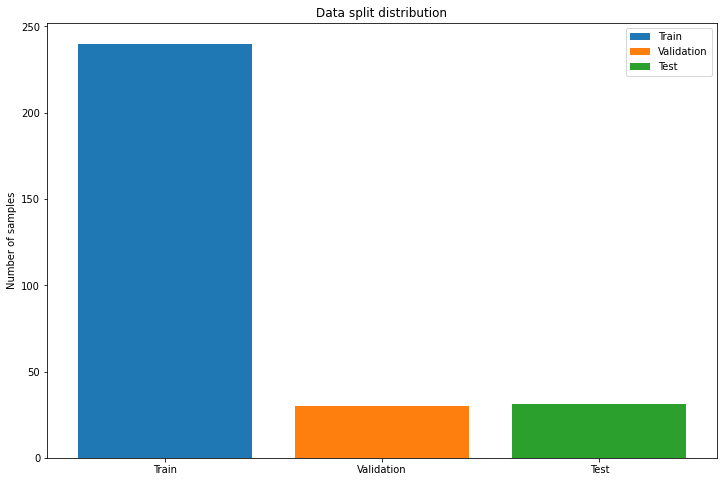

240
30
31


In [ ]:
# Create train, validation, and test dataset instances
train_dataset = BasicDataset('train')
valid_dataset = BasicDataset('val')
test_dataset = BasicDataset('test')



plt.figure(figsize=(12,8))
plt.title('Data split distribution')
plt.bar(0, len(train_dataset), label='Train')
plt.bar(1, len(valid_dataset), label='Validation')
plt.bar(2, len(test_dataset), label='Test')
plt.ylabel('Number of samples')
plt.xticks([0,1,2],['Train', 'Validation', 'Test'])
plt.legend()
plt.show()
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

Also, let's check if our `BasicDataset` implementation works by pulling out a random sample of the training set.

(Don't forget that we need to reverse some of the preprocessing steps, like changing the axis format and rescaling the image intensity to `[0, 255]`)

x shape is torch.Size([3, 512, 512])
y shape is torch.Size([1, 512, 512])


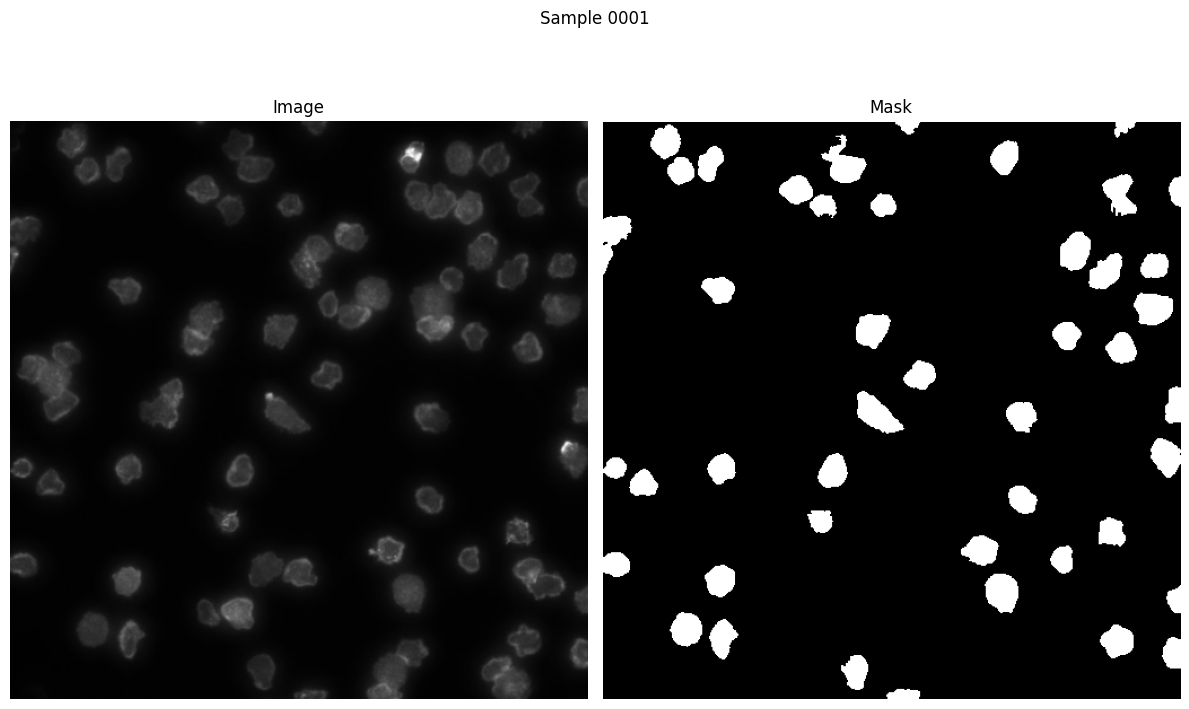

In [ ]:
sample = np.random.randint(0, len(train_dataset))
data = train_dataset.__getitem__(0)
x = data['image']
y = data['mask']
idx = data['img_id']

print(f'x shape is {x.shape}')
print(f'y shape is {y.shape}')

plt.figure(figsize=(12, 8), dpi=100)
plt.suptitle(f'Sample {idx:04d}')
img = np.transpose(x, (1,2,0))
mask = y[0]
plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()




Now that we have made sure our dataset implementation works fine, we can make the `DataLoader` per each set. We will set the batch size as **4** for all sets.

<span style="color:red;font-size:18px;" font>Important Note</span>: For this tutorial, we choose to work with **1000** samples for training, **200** samples for validation, and **200** samples for testing to reduce the training time. In your final project, you should use the whole dataset.

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=0, pin_memory=True)

### 2. Implement U-Net model (Modified version)

Now that we have set up our data loaders, we can implement the architecture.

The original [U-Net architecture](https://arxiv.org/abs/1505.04597) is:

<div align="center">
  <img width="800px" src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" />
</div>

Nevertheless, as you can see, the input array and the output array are in different shapes. Thus, we will design a similar network but with a little bit of modification so that the input shape and output shape remain the same.

The following image show what exactly we will implement:

<div align="center">
  <img width="800px" src="https://github.com/soroush361/AoE_BME/blob/main/modified_UNet_arch_2.png?raw=true" />
</div>


To implement this modified U-Net, we first define four blocks that we will use multiple times while designing the complete architecture. \
`DoubleCov` is block that contains these layers: Conv2d->BatchNormalization->ReLU->Conv2d->BatchNormalization->ReLU \
`Down` is a downsampling block that contains Maxpooling and `DoubleConv` after Maxpooling. (Decoding layers) \
`Up` is an upsampling block that upsamples the input then pass it through a `DoubleConv.` (Encoding Layers) \
`OutConv` is just a $(1\times1)$ 2D convolution followed by a Sigmoid activation that serves as an output layer in our U-Net model.


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.nn import init

# def init_weights(net, init_type = 'normal', gain = 0.02):
#     def init_func(m):
#         classname = m.__class__.__name__
#         if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
#             if init_type == 'normal':
#                 init.normal_(m.weight.data, 0.0, gain)
#             elif init_type == 'xavier':
#                 init.xavier_normal_(m.weight.data, gain = gain)
#             elif init_type == 'kaiming':
#                 init.kaiming_normal_(m.weight.data, a = 0, mode = 'fan_in')
#             elif init_type == 'orthogonal':
#                 init.orthogonal_(m.weight.data, gain = gain)
#             else:
#                 raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
#             if hasattr(m, 'bias') and m.bias is not None:
#                 init.constant_(m.bias.data, 0.0)
#         elif classname.find('BatchNorm2d') != -1:
#             init.normal_(m.weight.data, 1.0, gain)
#             init.constant_(m.bias.data, 0.0)

#     print('initialize network with %s' % init_type)
#     net.apply(init_func)


class conv_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace = True),
            nn.Conv2d(ch_out, ch_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace = True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x


class resconv_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(resconv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace = True),
            nn.Conv2d(ch_out, ch_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace = True)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in, ch_out, kernel_size = 1, stride = 1, padding = 0)
        

    def forward(self,x):
        
        residual =  self.Conv_1x1(x)
        x = self.conv(x)
        
        return x+residual


class up_conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(ch_in, ch_out, kernel_size = 3, stride = 1, padding = 1, bias = True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace = True)
        )
        self.Conv_1x1 = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(ch_in, ch_out, kernel_size = 1, stride = 1, padding = 0))

    def forward(self,x):
#         residual =  self.Conv_1x1(x)
        x = self.up(x) 
        return x


class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size = 1, stride = 1, padding = 0, bias = True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size = 1, stride = 1, padding = 0, bias = True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size = 1, stride = 1, padding = 0, bias = True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace = True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)

        return x * psi



      





Now we can mix the above modules to build our architecture.

We will assign `name`, `n_channels`, and `n_classes` to our implementation for organization purposes. In this case, we may set `name` as an arbitrary name (e.g., 'MyUNet'), `n_channels` must be **3** (Since the input image is three-channeled), and `n_classes` must be **1** (Because we have one class: 0 for background, and 1 for cells). If we had more than one class, we need to consider the background as a seperated class.

In [ ]:
class ResAttU_Net(nn.Module):
    def __init__(self, name, UnetLayer, img_ch = 1, output_ch = 1, first_layer_numKernel = 64):
        super(ResAttU_Net, self).__init__()
        self.name = name
        self.UnetLayer = UnetLayer
        self.Maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.Conv1 = resconv_block(ch_in = img_ch, ch_out = first_layer_numKernel)
        self.Conv2 = resconv_block(ch_in = first_layer_numKernel, ch_out = 2 * first_layer_numKernel)
        self.Conv3 = resconv_block(ch_in = 2 * first_layer_numKernel, ch_out = 4 * first_layer_numKernel)
        self.Conv4 = resconv_block(ch_in = 4 * first_layer_numKernel, ch_out = 8 * first_layer_numKernel)
        self.Conv5 = resconv_block(ch_in = 8 * first_layer_numKernel, ch_out = 16 * first_layer_numKernel)
        # self.Conv6 = conv_block(ch_in = 16 * first_layer_numKernel, ch_out = 32 * first_layer_numKernel)

        # self.Up6 = up_conv(ch_in = 32 * first_layer_numKernel, ch_out = 16 * first_layer_numKernel)
        # self.Att6 = Attention_block(F_g = 16 * first_layer_numKernel, F_l = 16 * first_layer_numKernel, F_int = 8 * first_layer_numKernel)
        # self.Up_conv6 = resconv_block(ch_in = 32 * first_layer_numKernel, ch_out = 16 * first_layer_numKernel)

        self.Up5 = up_conv(ch_in = 16 * first_layer_numKernel, ch_out = 8 * first_layer_numKernel)
        self.Att5 = Attention_block(F_g = 8 * first_layer_numKernel, F_l = 8 * first_layer_numKernel, F_int = 4 * first_layer_numKernel)
        self.Up_conv5 = conv_block(ch_in = 16 * first_layer_numKernel, ch_out = 8 * first_layer_numKernel)

        self.Up4 = up_conv(ch_in = 8 * first_layer_numKernel, ch_out = 4 * first_layer_numKernel)
        self.Att4 = Attention_block(F_g = 4 * first_layer_numKernel, F_l = 4* first_layer_numKernel, F_int = 2 * first_layer_numKernel)
        self.Up_conv4 = conv_block(ch_in = 8 * first_layer_numKernel, ch_out = 4 * first_layer_numKernel)
        
        self.Up3 = up_conv(ch_in = 4 * first_layer_numKernel, ch_out = 2 * first_layer_numKernel)
        self.Att3 = Attention_block(F_g = 2 * first_layer_numKernel, F_l = 2 * first_layer_numKernel, F_int = first_layer_numKernel)
        self.Up_conv3 = conv_block(ch_in = 4 * first_layer_numKernel, ch_out = 2 * first_layer_numKernel)
        
        self.Up2 = up_conv(ch_in = 2 * first_layer_numKernel, ch_out = first_layer_numKernel)
        self.Att2 = Attention_block(F_g = first_layer_numKernel, F_l = first_layer_numKernel, F_int = int(first_layer_numKernel / 2))
        self.Up_conv2 = conv_block(ch_in = 2 * first_layer_numKernel, ch_out = first_layer_numKernel)

        self.Conv_1x1 = nn.Conv2d(first_layer_numKernel, output_ch, kernel_size = 1, stride = 1, padding = 0)

    def forward(self, x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)
        
        # d3 = self.Up3(x3)

           
        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        # d4 = self.Up4(x4)

            
        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # x6 = self.Maxpool(x5)
        # x6 = self.Conv6(x6)

        # # decoding + concat path
        # d6 = self.Up6(x6)
        # x5 = self.Att6(g = d6, x = x5)
        # d6 = torch.cat((x5, d6), dim = 1)
        # d6 = self.Up_conv6(d6)

        d5 = self.Up5(x5)
        x4 = self.Att5(g = d5, x = x4)
        d5 = torch.cat((x4, d5), dim = 1)        
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g = d4, x = x3)
        d4 = torch.cat((x3, d4), dim = 1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g = d3, x = x2)
        d3 = torch.cat((x2, d3), dim = 1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g = d2, x = x1)
        d2 = torch.cat((x1, d2), dim = 1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

Now we can create an instance of our implemented model.

In [ ]:
	# self.unet = None
	# 	self.optimizer = None
img_ch = 3
		# self.GT_ch = config.GT_ch
output_ch = 1
first_layer_numKernel = 64
UnetLayer = 5
my_Net = ResAttU_Net(name = 'residual_attention_unet',UnetLayer = UnetLayer, img_ch = img_ch, output_ch = output_ch, first_layer_numKernel = first_layer_numKernel)
# self.unet = ResAttU_Net(UnetLayer = self.UnetLayer, img_ch = self.img_ch, output_ch = self.output_ch, first_layer_numKernel = self.first_layer_numKernel)
my_Net.cuda()


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

Although we have not trained our model, we may see the output with random weights. Thus, we will pull a batch of test data loader, get the network's output, and plot it.

In [ ]:
# Take the first batch
for batch in test_dataloader:
    sample_batch = batch
    break
    
# Generate network prediction
with torch.no_grad():
    y_pred = my_Net(sample_batch['image'].cuda())

# Print the shapes of the images, masks, predicted masks
print('Sample batch \'image \'shape is: {0}\nSample batch \'mask\' shape is: {1}\nPredicted mask shape is: {2}'.format(sample_batch['image'].shape, 
                                                                                                                       sample_batch['mask'].shape,
                                                                                                                       y_pred.shape
                                                                                                                      ))

# Conver Pytorch tensor to numpy array then reverse the preprocessing steps
img = (sample_batch['image'][0].numpy().transpose(1,2,0) * 255).astype('uint8')
msk = (sample_batch['mask'][0][0,:,:].numpy() * 255).astype('uint8')

# Exctract the relative prediction mask and threshold the probablities (>0.5)
pred_msk = (y_pred.cpu().numpy()[0][0,:,:] * 255).astype('uint8')
pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

# Plot the smaple, ground truth, the prediction probability map, and the final predicted mask
plt.figure(figsize=(24,18))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(2,4,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img)
plt.axis('off')

plt.subplot(2,4,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')

plt.subplot(2,4,3)
plt.title('Non-trained Network Prediction Output \n(probability [0, 1])', fontsize=15)
plt.imshow(pred_msk, cmap='gray')
plt.axis('off')

plt.subplot(2,4,4)
plt.title('Non-trained Thresholdded Binary Prediction (threshold > 0.5)', fontsize=15)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

input_overlayed_GT = img.copy()
input_overlayed_GT[msk == 255, :] = [0, 255, 0]
plt.subplot(2,4,5)
plt.title('Input Image overlayed with Ground Truth', fontsize=15)
plt.imshow(input_overlayed_GT)
plt.axis('off')

input_overlayed_Pred = img.copy()
input_overlayed_Pred[pred_msk_binary == 255, :] = [255, 0, 0]
plt.subplot(2,4,6)
plt.title('Input Image overlayed with Prediction', fontsize=15)
plt.imshow(input_overlayed_Pred)
plt.axis('off')

GT_overlayed_prediction = np.zeros_like(img)
GT_overlayed_prediction[msk == 255, 1] = 255
GT_overlayed_prediction[pred_msk_binary == 255, 0] = 255
plt.subplot(2,4,7)
plt.title('Ground Truth overlayed with Prediction', fontsize=15)
plt.imshow(GT_overlayed_prediction)
plt.axis('off')

plt.tight_layout()
plt.show()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

As you can see, the predicted mask is not nearly close to the ground truth because we didn't train the network!

### 3. Train the model

#### 3.1 Optimizer and Loss function

Before working on the training loop, let's define the **optimizer** and the **loss function**.
In this example, we will use the **"ADAM"** algorithm for the optimizer, and for the loss function, we will use **"Binary Cross-Entropy"**. You may change these later to see how different optimization algorithms and loss functions may affect the performance.

For the optimizer, we need to provide the network parameters and define the learning rate. Let's set it as `0.001` for now.

In [ ]:
def dice_loss(y_pred, y_true):
#         print(y_pred.shape)
        eps = 0.0001
        inter = torch.dot(y_pred.view(-1).float(), y_true.view(-1).float())
        union = torch.sum(y_pred.float()) + torch.sum(y_true.float())
#         return 1 - ((2 * inter.float() + eps) / (union.float() + eps)).cpu().detach().numpy()
        return 1 - ((2 * inter.float() + eps) / (union.float() + eps))

In [ ]:
# optimizer = torch.optim.Adam(my_Net.parameters(), lr=0.0005)
optimizer = torch.optim.Adam(my_Net.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# pw = np.array([0.9, 0.1])
# pw = torch.from_numpy(pw).type(torch.FloatTensor)
# loss_function = nn.BCEWithLogitsLoss()
loss_function = nn.BCELoss()
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.97)
# loss_function = dice_loss()

#### 3.2 Training loop

In MNIST example, you saw the training loop is very complecated and there are alot of things happening at the same time. Thus, we provide you with a single function, name `traine_net`, that takes the following arguments and trains the network. The input arguments are:

1. `net`: The model you want to train.
2. `epochs`: Number of epochs you want to train the network.
3. `train_dataloader`: The training set `DataLoader`.
4. `valid_dataloader`: The validation set `DataLoader`.
5. `optimizer`: The optimizer algorithm.
6. `loss_function`: The loss function.

This function creates a directory in `/kaggle/working/{model_name}`, and saves the model weights per each epoch (starts at 1 for the first epoch). Also, it will calculate the [DICE score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) for both training and validation samples.
The return values of this function are:

1. `train_loss`: A list of average training loss per each epoch.
2. `train_dice`: A list of average training DICE score per each epoch.
3. `valid_loss`: A list of average validation loss per each epoch.
4. `valid_dice`: A list of average validation DICE score per each epoch.

In [ ]:
from scipy import misc,ndimage
# from pytorchtools import EarlyStopping
# Define a function that computes the DICE score for binary segmentation
def dice_coeff_binary(y_pred, y_true):
        """Values must be only zero or one."""
        eps = 0.0001
        inter = torch.dot(y_pred.view(-1), y_true.view(-1))
        union = torch.sum(y_pred) + torch.sum(y_true)
        return ((2 * inter.float() + eps) / (union.float() + eps)).cpu().numpy()

def Jaccard_coeff_binary(y_pred, y_true):
        """Values must be only zero or one."""
        eps = 0.0001
        inter = torch.dot(y_pred.view(-1), y_true.view(-1))
        sum1 = torch.sum(y_pred) 
        sum2 = torch.sum(y_true)
        return (( inter.float() + eps) / (sum1.float() + sum2.float() - inter.float() + eps)).cpu().numpy()

# The training function
def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    
    if not os.path.isdir('/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/saved_model/{0}'.format(net.name)):
        os.mkdir('/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/saved_model/{0}'.format(net.name))
    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = list()
    valid_loss = list()
    train_dice = list()
    valid_dice = list()
    train_Jaccard = list()
    valid_Jaccard = list()
    count = 0
    
    for epoch in range(epochs):
        
        ################################################################################################################################
        ########################################################### Training ###########################################################
        ################################################################################################################################
        net.train()
        train_batch_loss = list()
        train_batch_dice = list()
        train_batch_Jaccard = list()
        
        for i, batch in enumerate(train_dataloader):
            count = count + 1
            # if count%10 == 0:
            #   print(count)
            # Load a batch and pass it to the GPU
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()
            
            

            # Produce the estimated mask using current weights
            y_pred = net(imgs)
            y_pred = torch.sigmoid(y_pred)
            

            # SR_flat = y_pred.view(y_pred.size(0), -1)
            # GT_flat = true_masks.view(true_masks.size(0), -1)
            # print(SR_flat.shape)
            # print(GT_flat.shape)

            # Compute the loss for this batch and append it to the epoch loss
#             loss = dice_loss(y_pred, true_masks)
            loss = loss_function(y_pred, true_masks)


            # # if self.edge_enhance == 'True':
            # GT_edge_enhanced = ndimage.gaussian_laplace(np.squeeze(true_masks.cpu().detach().numpy()), sigma = 5)
            # GT_edge1 = torch.tensor(np.int64(GT_edge_enhanced < -0.001))
            # GT_edge2 = torch.tensor(np.int64(GT_edge_enhanced > 0.001))
            # y_hat = torch.cat((torch.squeeze(SR_flat), torch.squeeze(y_pred)[GT_edge1 == 1], torch.squeeze(y_pred)[GT_edge2 == 1]), 0)
            # print(SR_flat)
            # print(torch.squeeze(y_pred)[GT_edge1 == 1])
            # y = torch.cat((torch.squeeze(GT_flat), torch.squeeze(true_masks)[GT_edge1 == 1], torch.squeeze(true_masks)[GT_edge2 == 1]), 0)
            
            # loss = loss_function(y_hat, y)

            batch_loss = loss.item()
            train_batch_loss.append(batch_loss)
            # print(loss)
            # train_batch_loss.append(batch_loss)

            # Make the thresholded mask to compute the DICE score
            pred_binary = (y_pred > 0.5).float()                    # You can change the probablity threshold!
            
            # Compute the DICE score for this batch and append it to the epoch dice
            batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            train_batch_dice.append(batch_dice_score)
            batch_Jaccard_score = Jaccard_coeff_binary(pred_binary, true_masks)
            train_batch_Jaccard.append(batch_Jaccard_score)
            

            # Reset gradient values
            optimizer.zero_grad()

            # Compute the backward losses
            loss.backward()

            # Update the weights
            optimizer.step()
#             exp_lr_scheduler.step()
            
            # Print the progress
            print(f'EPOCH {epoch + 1}/{epochs} - Training Batch {i+1}/{n_train} - Loss: {batch_loss}, DICE score: {batch_dice_score}', end='\r')
        
        average_training_loss = np.array(train_batch_loss).mean()
        average_training_dice = np.array(train_batch_dice).mean()
        average_training_Jaccard = np.array(train_batch_Jaccard).mean()
        train_loss.append(average_training_loss)
        train_dice.append(average_training_dice)
        train_Jaccard.append(average_training_Jaccard)
        
        ################################################################################################################################
        ########################################################## Validation ##########################################################
        ################################################################################################################################
        
        net.eval()
        valid_batch_loss = list()
        valid_batch_dice = list()
        valid_batch_Jaccard = list()
        # early_stopping = EarlyStopping(patience=patience, verbose=True)
        
        # This part is almost the same as training with the difference that we will set all layers to evaluation mode (effects some layers such as BN and Dropout) and also
        # we don't need to calculate the gradient since we are only evaluating current state of the model. This will speed up the process and cause it to consume less memory.
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):

                # Load a batch and pass it to the GPU
                imgs = batch['image'].cuda()
                true_masks = batch['mask'].cuda()

                # Produce the estimated mask using current weights
                y_pred = net(imgs)
                y_pred = torch.sigmoid(y_pred)

                # Compute the loss for this batch and append it to the epoch loss
#                 loss = dice_loss(y_pred, true_masks)
                loss = loss_function(y_pred, true_masks)
                batch_loss = loss.item()
                valid_batch_loss.append(batch_loss)

                # Make the thresholded mask to compute the DICE score
                pred_binary = (y_pred > 0.5).float()                    # You can change the probablity threshold!

                # Compute the DICE score for this batch and append it to the epoch dice
                batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
                valid_batch_dice.append(batch_dice_score)
                batch_Jaccard_score = Jaccard_coeff_binary(pred_binary, true_masks)
                valid_batch_Jaccard.append(batch_Jaccard_score)

                # Print the progress
                print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {batch_loss}, DICE score: {batch_dice_score}', end='\r')
                
        average_validation_loss = np.array(valid_batch_loss).mean()
        average_validation_dice = np.array(valid_batch_dice).mean()
        average_validation_Jaccard = np.array(valid_batch_Jaccard).mean()
        valid_loss.append(average_validation_loss)
        valid_dice.append(average_validation_dice)
        valid_Jaccard.append(average_validation_Jaccard)

        
        
        
        
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training DICE score: {average_training_dice}, Training Jaccard score: {average_training_Jaccard}, Validation Loss: {average_validation_loss}, Validation DICE score: {average_validation_dice}, Validation Jaccard score: {average_validation_Jaccard}')

        ################################################################################################################################
        ###################################################### Saveing Checkpoints #####################################################
        ################################################################################################################################
        torch.save(net.state_dict(), f'/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/saved_model/{net.name}/epoch_{epoch+1:03}.pth')
        
        # if (len(valid_loss) > patience*2):
        #   if (np.mean(valid_loss[-patience*2:-patience]) <= np.mean(valid_loss[-patience:])):
        #     counter = counter + 1
        #     if counter > patience:
        #       print('Validation loss stop decreasing. Stop training.')
        #       break   
    
    return train_loss, train_dice, valid_loss, valid_dice

Now that we have everything in place, we can call the `train_net` function on our model and let it be trained for **10** epochs.

In [ ]:
EPOCHS = 120

train_loss, train_dice, valid_loss, valid_dice = train_net(my_Net, EPOCHS, train_dataloader, valid_dataloader, optimizer, loss_function)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

Save the Model

In [ ]:
os.getcwd()

In [ ]:
a = 12%10
print(a)

In [ ]:
os.chdir("/content/drive/MyDrive/Jan8th/")
# cd /content/drive/MyDrive/Result_res_att_unet
# /content/res_att_unet

In [ ]:
!mkdir -p saved_model

In [ ]:
torch.save(my_Net.state_dict(), '/content/drive/MyDrive/Jan11th/saved_model/my_Net.pth')

### 4. Display results

Now that we have trained our network, let us see how it will perform on the test set. 

First, let us plot the learning curve and the DICE scores per epoch.

In [ ]:
plt.figure(figsize=(15,8))
plt.suptitle('Learning Curve', fontsize=18)

plt.subplot(1,2,1)
plt.plot(np.arange(EPOCHS)+1, train_loss, '-o', label='Training Loss')
plt.plot(np.arange(EPOCHS)+1, valid_loss, '-o', label='Validation Loss')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(EPOCHS)+1, train_dice, '-o', label='Training DICE score')
plt.plot(np.arange(EPOCHS)+1, valid_dice, '-o', label='Validation DICE score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('DICE score', fontsize=15)
plt.legend()

plt.tight_layout()
plt.show()


Then, let us see in which epoch the model obtained the highest validation DICE score and load the weights of that epoch as our best model weights.

In [ ]:
# best_epoch = np.argmax(valid_dice) #+ 1 # The plus one is because the epochs starts at 1.
best_epoch = 129
# best_epoch = 7
print(f'Best epoch is epoch {best_epoch}')

# state_dict = torch.load(f'/content/drive/MyDrive/xin_dataset/saved_model/epoch_{best_epoch:03}.pth')
state_dict = torch.load(f'/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/saved_model/residual_attention_unet/epoch_{best_epoch:03}.pth')
# state_dict = torch.load(f'/content/drive/MyDrive/Jan11th/residual_attention_unet/epoch_{best_epoch:03}.pth')

my_Net.load_state_dict(state_dict)
my_Net.cuda()

Now we can check the performance of the best model on our previously pulled example. (The same scripts must work!)

In [ ]:
# Take the first batch
for batch in test_dataloader:
    sample_batch = batch
    break
    
# Generat network prediction
with torch.no_grad():
    y_pred = my_Net(sample_batch['image'].cuda())

# Print the shapes of the images, masks, predicted masks
print('Sample batch \'image \'shape is: {0}\nSample batch \'mask\' shape is: {1}\nPredicted mask shape is: {2}'.format(sample_batch['image'].shape, 
                                                                                                                       sample_batch['mask'].shape,
                                                                                                                       y_pred.shape
                                                                                                                      ))

# Conver Pytorch tensor to numpy array then reverse the preprocessing steps
img = (sample_batch['image'][0].numpy().transpose(1,2,0) * 255).astype('uint8')
msk = (sample_batch['mask'][0][0,:,:].numpy() * 255).astype('uint8')

# Exctract the relative prediction mask and threshold the probablities (>0.5)
pred_msk = (y_pred.cpu().numpy()[0][0,:,:] * 255).astype('uint8')
intensity_th = 0.1
pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > intensity_th) * 255).astype('uint8')

# Take the image id for display
img_id = sample_batch['img_id'][0]

# Plot the smaple, ground truth, the prediction probability map, and the final predicted mask
plt.figure(figsize=(24,18))
plt.suptitle(f'Test sample Image {img_id}', fontsize=18)

plt.subplot(2,4,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img)
plt.axis('off')

plt.subplot(2,4,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')

plt.subplot(2,4,3)
plt.title('Final Network Prediction Output \n(probability [0, 1])', fontsize=15)
plt.imshow(pred_msk, cmap='gray')
plt.axis('off')

plt.subplot(2,4,4)
plt.title('Final Thresholdded Binary Prediction (threshold > 0.5)', fontsize=15)
plt.imshow(pred_msk_binary, cmap='gray')
plt.axis('off')

input_overlayed_GT = img.copy()
input_overlayed_GT[msk == 255, :] = [0, 255, 0]
plt.subplot(2,4,5)
plt.title('Input Image overlayed with Ground Truth', fontsize=15)
plt.imshow(input_overlayed_GT)
plt.axis('off')

input_overlayed_Pred = img.copy()
input_overlayed_Pred[pred_msk_binary == 255, :] = [255, 0, 0]
plt.subplot(2,4,6)
plt.title('Input Image overlayed with Prediction', fontsize=15)
plt.imshow(input_overlayed_Pred)
plt.axis('off')

GT_overlayed_prediction = np.zeros_like(img)
GT_overlayed_prediction[msk == 255, 1] = 255
GT_overlayed_prediction[pred_msk_binary == 255, 0] = 255
plt.subplot(2,4,7)
plt.title('Ground Truth overlayed with Prediction', fontsize=15)
plt.imshow(GT_overlayed_prediction)
plt.axis('off')

plt.tight_layout()
plt.show()

As it is clear, the model is predicting the ground truth much better compared to before training.

However, we need to compute the overall performance of the model on all test samples. Then, similar to the `train_net` function, we can define a `test_net` function that tests our model on test samples and save the prediction masks in the `/kaggle/working/pred_mask` folder.

This function takes the following arguments:

1. `net`: The model we want to test.
2. `test_dataloader`: The `DataLoader` for the test set.
3. `loss_function`: The loss function to calculate the loss.

This function returns:
1. `test_loss`: The average test loss.
2. `test_dice`: The average test DICE score.
3. `test_accuracy`: The overall accuracy of the model.
4. `test_CM`: The normalized confusion matrix of the model.



In [ ]:
def test_net(net, test_dataloader, loss_function):
    # Create the pred_mask folder
    # if not os.path.isdir('/content/drive/MyDrive/Result_v10'):
    #     os.mkdir('/content/drive/MyDrive/Result_v10')
    
    net.eval()
    
    n_test = len(test_dataloader)
    test_batch_loss = list()
    test_batch_dice = list()
    test_batch_accuray = list()
    test_batch_CM = list()

    # This part is almost the same as the validation loop in `train_net` function. 
    # The difference is that we will calculate the accuracy and confusion matrix per each batch and save the predicted images.
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):

            # Load a batch and pass it to the GPU
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()
            img_ids = batch['img_id'].numpy().astype('int')

            # Produce the estimated mask using current weights
            y_pred = net(imgs)
            y_pred = torch.sigmoid(y_pred)

            # Compute the loss for this batch and append it to the epoch loss
            # loss = dice_loss(y_pred, true_masks)
            loss = dice_loss(y_pred, true_masks)
            batch_loss = loss.item()
            test_batch_loss.append(batch_loss)

            # Make the thresholded mask to compute the DICE score
            pred_binary = (y_pred > 0.5).float()                    # You can change the probablity threshold!

            # Compute the DICE score for this batch and append it to the epoch dice
            batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            test_batch_dice.append(batch_dice_score)
            
            # Save the predicted masks
            # for idx, pred_msk in enumerate(pred_binary):
            #     cv2.imwrite(f'/content/drive/MyDrive/Result_v10/pred_mask_{img_ids[idx]:04}.png', np.expand_dims((pred_msk[0].cpu().numpy() * 255).astype('uint8'), axis=-1))
            
            # Vectorize the true mask and predicted mask for this batch
            vectorize_true_masks = true_masks.view(-1).cpu().numpy()
            vectorize_pred_masks = pred_binary.view(-1).cpu().numpy()
            
            # Compute the accuracy for this batch and append to the overall list
            batch_accuracy = accuracy_score(vectorize_true_masks, vectorize_pred_masks)
            test_batch_accuray.append(batch_accuracy)
            
            # Compute the normalized confusion matrix for this batch and append to the overall list
            batch_CM = confusion_matrix(vectorize_true_masks, vectorize_pred_masks, normalize='true', labels=[0, 1])
            test_batch_CM.append(batch_CM)

            # Print the progress
            print(f'Test Batch {i+1}/{n_test} - Loss: {batch_loss}, DICE score: {batch_dice_score}, Accuracy: {batch_accuracy}', end='\r')

    test_loss = np.array(test_batch_loss).mean()
    test_dice = np.array(test_batch_dice).mean()
    test_accuracy = np.array(test_batch_accuray).mean()
    test_CM = np.array(test_batch_CM).mean(axis=0)
    
    return test_loss, test_dice, test_accuracy, test_CM

Let us use the function and see how it works!

Note: The accuracy and confusion matrix are computed on the CPU; thus, this function might be slower.

In [ ]:
test_loss, test_dice, test_accuracy, test_CM = test_net(my_Net, test_dataloader, loss_function)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test overall accuracy: {test_accuracy}')

In [ ]:
import torchvision
from torchvision import transforms, utils
data_root_folder = '/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/classification/'

class ClassificationBasicDataset(TensorDataset):
    # This function takes folder name ('train', 'valid', 'test') as input and creates an instance of BasicDataset according to that folder.
    # Also if you'd like to have less number of samples (for evaluation purposes), you may set the `n_sample` with an integer.
    def __init__(self, n_sample=None):
        self.folder = os.path.join(data_root_folder)
        self.imgs_dir = os.path.join(self.folder, 'raw')
        self.masks_dir = os.path.join(self.folder, 'mask')
         
        print(self.imgs_dir)
        
        self.imgs_file = sorted(glob.glob(os.path.join(self.imgs_dir, '*.jpg')))
        self.masks_file = sorted(glob.glob(os.path.join(self.masks_dir, '*_mask.jpg')))
        
        assert len(self.imgs_file) == len(self.masks_file), 'There are some missing images or masks in {0}'.format(folder)
        
        # If n_sample is not None (It has been set by the user)
        if not n_sample or n_sample > len(self.imgs_file):
            n_sample = len(self.imgs_file)
        
        self.n_sample = n_sample
        self.ids = list([i+1 for i in range(n_sample)])
        

        for i in range(n_sample):
            img_basename = os.path.basename(self.imgs_file[i])
            
    # This function returns the lenght of the dataset (AKA number of samples in that set)
    def __len__(self):
        return self.n_sample
    
    # This function takes an index (i) which is between 0 to `len(BasicDataset)` (The return of the previous function), then returns RGB image, 
    # mask (Binary), and the index of the file name (Which we will use for visualization). The preprocessing step is also implemented in this function.
    def __getitem__(self, i):
        idx = self.ids[i]
        img = cv2.imread(self.imgs_file[i], cv2.IMREAD_COLOR)
        mask = cv2.imread(self.masks_file[i], cv2.IMREAD_GRAYSCALE)

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = mask

        
        
        
        # Scale between 0 to 1
        img = np.array(img) / 255.0
        mask = np.array(mask) / 255.0
        
        # Make sure that the mask are binary (0 or 1)
        mask[mask <= 0.5] = 0.0
        mask[mask > 0.5] = 1.0
        
        # Add an axis to the mask array so that it is in [channel, width, height] format.
        mask = np.expand_dims(mask, axis=0)
        
        # HWC to CHW
        img = np.transpose(img, (2, 0, 1))
        img = torch.from_numpy(img).type(torch.FloatTensor)
        mask = torch.from_numpy(mask).type(torch.FloatTensor)

        padding = nn.ConstantPad2d((10, 10, 11, 11), 0)
        img = padding(img)
        mask = padding(mask)
        
        sample = {'image':img, 'mask':mask}
        img = sample['image']
        mask = sample['mask']
        
        
        
        return {
            'image': img,
            'mask': mask,
            'img_id': idx
        }

In [ ]:
test_dataset = ClassificationBasicDataset()
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=2, pin_memory=True)

In [ ]:
test_loss, test_dice, test_accuracy, test_CM = test_net(my_Net, test_dataloader, loss_function)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test overall accuracy: {test_accuracy}')